In [1]:
%matplotlib inline

# Imports

In [2]:
from holoinfer.model import hologram, math

import numpy as np
import scipy.optimize as op

import matplotlib.pyplot as plt

import emcee

from lmfit import minimize, Parameters

# New Functions

In [3]:
def chisq(obs, exp, axis=0):
    return np.sum((obs - exp)**2/exp, axis=axis)

In [4]:
def dist(*vec):
    return np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2)

In [5]:
def rg_sphere_holo(position, k, cx, cy, cz, re_m, im_m, a):
    r = (position - np.array([cx, cy, cz])).T
    r = dist(r[0], r[1], r[2])

    z = cz
    theta = np.arccos(z / r)

    x = k * a
    u = 2 * x * np.sin(.5 * theta)
    g = 3 / u ** 3 * (np.sin(u) - u * np.cos(u))

    s2_mag = k ** 3 * a ** 3 * np.sqrt(re_m * re_m + im_m * im_m - 2 * re_m + 1) * 2 / 3 * np.abs(np.cos(theta)) * g
    s2_phase = np.arctan((1 - re_m) / im_m) if im_m != 0 else np.pi / 2

    holo_scatt = (1 / (k * r) * s2_mag) ** 2
    holo_inter = 2 * 1/(k*r) * np.sqrt(s2_mag**2) * np.sin(k*(r-z) + s2_phase)

    holo_full = holo_scatt + holo_inter + 1

    return holo_full

In [ ]:
def loglikelihood(theta, x=None, k=None, obs=None): 
    cx, cy, cz, re_m, im_m, a = theta
    exp = rg_sphere_holo(x, k, *theta)
    return 0.5*np.sum((obs-exp)**2)

In [6]:
def residual(params, grid, data):
    k = params['wavevector']
    x = params['x']
    y = params['y']
    z = params['z']
    re_m = params['rem']
    im_m = params['imm']
    a = params['r']
    
    model = rg_sphere_holo(grid, k, x, y, z, re_m, im_m, a)

    return data-model

# Generate Holograms

In [7]:
scaling = 1
pixel_size = 0.0858/scaling # All units are in microns
grid_size = int(500*scaling)

illum_wavelength = .660
med_index = 1.33

illum_wavenumber = 2*np.pi/illum_wavelength


x = y = np.linspace(0, pixel_size*grid_size, int(grid_size))
z = 0
detector_grid = math.cartesian(x, y, z)

In [8]:
sc_center = np.array([150*pixel_size, 150*pixel_size, 5])
sc_radius = .5
sc_index = 1.4734
rel_index = np.array([sc_index/med_index, 0])

obs = rg_sphere_holo(detector_grid, illum_wavenumber, *sc_center, *rel_index, sc_radius)

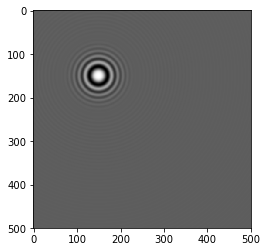

In [9]:
obs_s = obs.reshape((grid_size, grid_size))

plt.gray()

plt.imshow(obs_s)

# Fit with scipy.optimize.minimize

In [ ]:
test = op.minimize(loglikelihood, [350*pixel_size, 200*pixel_size, 8, 1.1, 0, 1], args=(detector_grid, illum_wavenumber, obs),
                  bounds=[(0, grid_size*pixel_size), (0, grid_size*pixel_size), (2, 8), (1,2), (0,1), (illum_wavelength/10, illum_wavelength*10)])

In [ ]:
calch = rg_sphere_holo(detector_grid, illum_wavenumber, *test['x'])
plt.imshow(calch.reshape(500,500))
plt.gray()

In [ ]:
chisq(calch, obs)

# Fit with lmfit

In [10]:
params = None
params = Parameters()
params.add('wavevector', value=2*np.pi/illum_wavelength, min=0, vary=False)
params.add('x', value=100*pixel_size, min=0, max=500*pixel_size)
params.add('y', value=150*pixel_size, vary=False)
params.add('z', value=5, vary=False)
params.add('rem', value=1.108, vary=False)
params.add('imm', value=0, vary=False)
params.add('r', value=.5, vary=False)

In [11]:
out = minimize(residual, params, args=(detector_grid, obs))

In [12]:
out.params.pretty_print()

Name           Value      Min      Max   Stderr     Vary     Expr Brute_Step
imm                0     -inf      inf        0    False     None     None
r                0.5     -inf      inf        0    False     None     None
rem            1.108     -inf      inf        0    False     None     None
wavevector      9.52        0      inf        0    False     None     None
x              7.928        0     42.9  0.00109     True     None     None
y              12.87     -inf      inf        0    False     None     None
z                  5     -inf      inf        0    False     None     None


In [13]:
out.chisqr

199.64674428531825

In [14]:
fitparams = [out.params[key].value for key in out.params]
infholo = rg_sphere_holo(detector_grid, *fitparams)

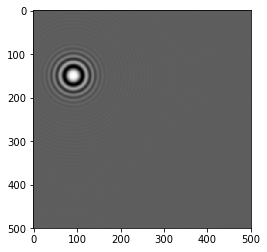

In [15]:
infholo_s = infholo.reshape((grid_size, grid_size))
plt.imshow(infholo_s)

In [17]:
out.params['x'].value / pixel_size

92.395235128453905